In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35643")
client

<Client: 'tcp://127.0.0.1:35643' processes=4 threads=8, memory=29.40 GiB>

# Import

In [7]:
import sys
sys.path.insert(1, '../')

In [8]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import pandas as pd
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
from scipy import ndimage
from numpy.polynomial import polynomial as P
import xrft
import inspect
import importlib
import xesmf as xe

# Plotting params

In [9]:
#%matplotlib widget
%matplotlib inline

In [10]:
line_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']

In [11]:
cmaps_list = ['Blues', 'Oranges', 'Greens', 'Reds']

# Load data

Choose cases

In [12]:
data=[dict() for i in range(3)]

In [13]:
data[0] = dict({'region' : '1', 'season' : 'fma', 'label' : 'GULFSTR wint'})
data[1] = dict({'region' : '2', 'season' : 'aso', 'label' : 'ACORES sum'})
data[2] = dict({'region' : '3', 'season' : 'aso', 'label' : 'MEDWEST sum'})

In [14]:
x_slice = slice(0,-1)
y_slice = slice(0,-1)

data_slice = dict(time_counter=slice(0,-1,300),y=y_slice,x=x_slice)  # take every 50-th hourly output
coord_slice = dict(y=y_slice,x=x_slice)
nb_of_time_chunks = 8

## eNATL60

In [15]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [16]:
%%time
for i in range(len(data)) :
    current_set = cat.eNATL60(region=data[i]['region'],datatype='surface_hourly', season=data[i]['season']).to_dask()
    current_set = current_set.drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set = current_set.isel(data_slice)
    #current_set = xr.open_mfdataset('/Users/ana/data/eNATL60_extractions/region'+data[i]['region']+'_'+data[i]['season']+'.nc', parallel=True).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    #drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
    current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
    #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
    #current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    current_set.load()
    current_set['x'] = np.arange(len(current_set['x']))
    current_set['y'] = np.arange(len(current_set['y']))
    data[i]['HR'] = current_set

CPU times: user 1.05 s, sys: 227 ms, total: 1.27 s
Wall time: 40.6 s


## eORCA025

In [18]:
for i in range(len(data)) :
    data[i]['LR'] = xr.open_mfdataset("../Data/eORCA025/region"+data[i]['region']+"_"+data[i]['season']+".nc", \
                                          chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}).\
    rename(nav_lat='lat', nav_lon='lon').isel(time_counter=slice(0,-1,7))

## Plot

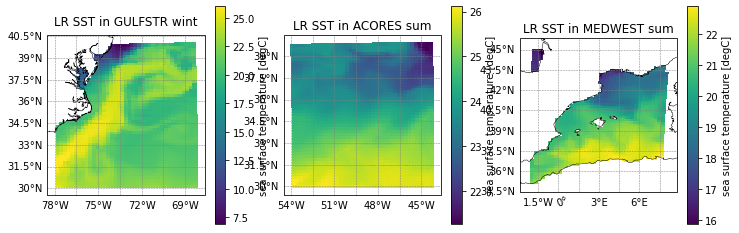

In [19]:
fig, axis = plt.subplots(ncols=len(data), nrows=1, figsize=(4*len(data),4), subplot_kw={'projection': ccrs.PlateCarree()}, squeeze=False)
for col in range(len(data)) :
    for row, dataSetKey in enumerate(['LR']) :
        data[col][dataSetKey].isel(time_counter=-1).sosstsst[coord_slice].plot(x='lon', y='lat', ax=axis[row,col])
        axis[row,col].set(title=dataSetKey + ' SST in ' + data[col]['label'])

for ax in axis.flatten() :
    ax.coastlines(color='k', lw=0.5)
    gl = ax.gridlines(draw_labels=True, x_inline=False, y_inline=False, color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False

# Regridding

In [20]:
# data_regrid = xe.util.grid_global(1./60., 1./60.)
# data_regrid = data_regrid.where((data_regrid.lon < -68) & (data_regrid.lon > -78) & (data_regrid.lat < 39) & (data_regrid.lat > 30), drop=True)
# data_regrid = data_regrid.where((data_regrid.lon < -68) & (data_regrid.lon > -78) & (data_regrid.lat < 39) & (data_regrid.lat > 30), drop=True)

In [21]:
regrid_method = "nearest_s2d"
#regrid_method = "bilinear"

In [22]:
%%time
for i in range(len(data)) :
    out_grid = data[i]['HR'].drop(['time_centered', 'depth', 'time_counter', 'e1t', 'e2t', 'e1f', 'e2f', 'e1v', 'e2v', 'e1u', 'e2u', 'nav_lat', 'nav_lon', 'tmask', 'sosstsst', 'sosaline'])
    regridder = xe.Regridder(data[i]['LR'], out_grid, regrid_method, unmapped_to_nan=True)
    data[i]['Regrid_LR'] = regridder(data[i]['LR'].drop(['sossheig', 'gradx_temp', 'grady_temp', 'gradx_sal', 'grady_sal', 'grad_temp', 'grad_sal']))

/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


CPU times: user 12.5 s, sys: 336 ms, total: 12.9 s
Wall time: 13 s


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


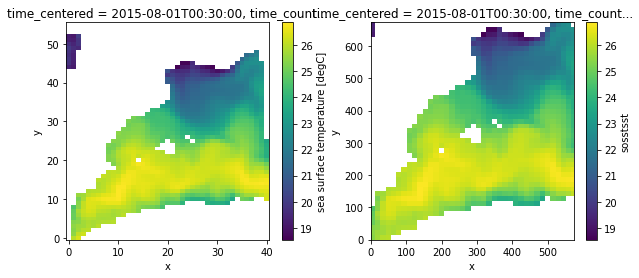

In [23]:
fig, axis = plt.subplots(ncols=2, nrows=1, figsize=(10,4))
data[2]['LR'].isel(time_counter=0).sosstsst.plot(ax=axis[0])
data[2]['Regrid_LR'].isel(time_counter=0).sosstsst.plot(ax=axis[1])
plt.show()

# Spectra

In [24]:
# without interpolation
def prepare_data_for_spec(data, variable) :
    res = data[variable].dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    if ("e1t" in data) :
        delta_x = res['e1t'].mean(skipna=True).values
        delta_y = res['e2t'].mean(skipna=True).values
    else :
        delta_x = gsw.distance(data.lon,data.lat).mean(skipna=True)
        delta_y = gsw.distance(data.lon,data.lat).mean(skipna=True)
        
    res.coords['x'] = res.coords['x']*delta_x
    res.coords['y'] = res.coords['y']*delta_y 

    # fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    res = res.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    res = res.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")

    res = res.drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon', 'e1t', 'e2t'], errors='ignore')
    return res

## Interpolation on a spatially uniform grid 

In [25]:
def uniform_grid_interpolation(data, variable) :
    # step0 : drop unecessary variables and coordinates out rows and cols consiting (almost) completely of nans
    step0 = data[variable].drop(['depth', 'e1f', 'e1u', 'e1v', 'e2f', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'], errors='ignore')
    step0 = step0.dropna(dim='y', thresh=3).dropna(dim='x', thresh=3)
    
    # switch to unit coordinates
    delta_x_min_m = step0['e1t'].min().values
    delta_y_min_m = step0['e2t'].min().values
    delta_min = np.min([delta_x_min_m, delta_y_min_m])
    new_x = np.cumsum(delta_min/step0['e1t'], axis=1)
    new_y = np.cumsum(delta_min/step0['e2t'], axis=0)

    # step 1 : fill in nans
    # avg = step0.mean().compute()
    # data_filled_nans = interpolated_field.fillna(avg)
    step1 = step0
    step1 = step1.interpolate_na(dim="x", method="linear", max_gap=15, limit=15)
    step1 = step1.interpolate_na(dim="y", method="linear", max_gap=15, limit=15)
    step1 = step1.interpolate_na(dim="x", method="nearest", fill_value="extrapolate")
    
    # step2 : interpotale onto a uniformly-spaced box
    step2 = step1.interp(x=new_x, y=new_y, method='linear')
    step2 = step2.dropna(dim='y', thresh=100).dropna(dim='x', thresh=100)

    if (step2.isnull().any().values == True) :
        step2 = step2.interpolate_na(dim="x", method="linear", fill_value="extrapolate")
        
    # step 3 : drop unecessey variables, add attribute, 
    step3 = step2.drop(['e1t', 'e2t'], errors='ignore')
    step3.attrs['delta_min'] = delta_min
    
    # return to unit coordinates (in meters) for correct computation of wavenumbers
    step3.coords['x'] = step3.coords['x']*delta_min
    step3.coords['y'] = step3.coords['y']*delta_min
    return step3

In [26]:
# fig, ax = plt.subplots(ncols=2, constrained_layout=True, figsize=(10,4))
# i_data = 2
# (data[i_data]['LR'].isel(time_counter=0)).sosstsst.plot(ax=ax[0])
# (uniform_grid_interpolation(data[i_data]['LR'], 'sosstsst').isel(time_counter=0)).plot(ax=ax[1])
# ax[0].set(title='Original filtered data')
# ax[1].set(title='Interpolated and filled data')
# plt.show()

## Isotropic power spectra

In [27]:
def wrapper_xrtf_isotropic_PS(data, variable, binning_factor=4) :
    #prepared_data = uniform_grid_interpolation(data.drop(['tmask']), variable) # with interpolation on a uniform grid
    prepared_data = prepare_data_for_spec(data.drop(['tmask'], errors='ignore'), variable) # without interpolation 
    isotropic_power_spec = xrft.isotropic_power_spectrum(prepared_data, dim=['x','y'], detrend='linear', nfactor=binning_factor, truncate=True)
    return isotropic_power_spec.rename('Spatial_spectrum')

In [28]:
# initialize data structure for storing histograms
spec=[dict() for i in range(len(data))]
for i in range(len(data)) :
    spec[i]['LR'] = dict({'label' : 'eORCA025'})
    spec[i]['HR'] = dict({'label' : 'eNATL60'})
    spec[i]['Regrid_LR'] = dict({'label' : 'Regrid eORCA025'})

In [29]:
%%time 
for i in range(len(data)) :
    for key_dict in ['LR', 'HR', 'Regrid_LR'] :
        spec[i][key_dict]['temp_spec'] = (wrapper_xrtf_isotropic_PS(data[i][key_dict], 'sosstsst')).mean(dim='time_counter').compute()

CPU times: user 12.7 s, sys: 4.66 s, total: 17.4 s
Wall time: 27 s


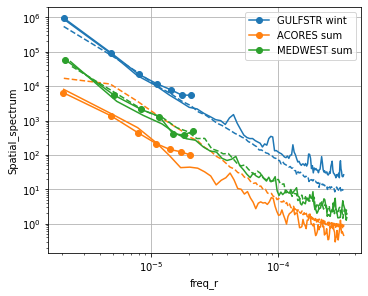

In [32]:
fig, ax = plt.subplots(ncols=1, constrained_layout=True, figsize=(5,4))
for data_i in range(len(data)) :
    spec[data_i]['LR']['temp_spec'].plot(x='freq_r', ax=ax, marker='o', color=line_colors[data_i], label=data[data_i]['label'])
    spec[data_i]['HR']['temp_spec'].plot(x='freq_r', ax=ax, ls='--', color=line_colors[data_i])
    spec[data_i]['Regrid_LR']['temp_spec'].plot(x='freq_r', ax=ax, color=line_colors[data_i])
ax.set(xscale='log', yscale='log'); ax.grid(True)
ax.legend()
plt.show()